# <font color='#0E6655'> </b> <center> WEATHER STATION CLUSTERING WITH DBSCAN </center> </b> </font>

## <font color='blue'> <b> Table of Contents </b> </font>

1. [Introduction](#1)
2. [Modules](#2)
3. [Loading, exploring and pre-processing data](#3)
4. [Station clustering based on their location ( Latitude & Longitude)](#4)
5. [Station clustering based on their location and temperature](#5)
6. [ANNEX](#annex)
7. [References](#references)

<a name="1"></a>
## <b> <font color='green'> 1. Introduction </b> </font>

DBSCAN is especially good for tasks such as class identification in a spatial context. The wonderful thing about DBSCAN is that it can find clusters of arbitrary shape without being affected by noise.

In this notebook, we will work with a dataset corresponding to weather stations in Canada. 

DBSCAN can be used, for example, to find groups of stations that exhibit the same weather conditions.


<a name="2"></a>
## <b> <font color='green'> 2. Modules </b> </font>

In [30]:
import pandas as pd
import warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')


<a name="3"></a>
## <b> <font color='green'> 3. Loading, exploring and pre-processing data </b> </font>

In [2]:
!cd data && ls

weather-stations.csv


In [3]:
df = pd.read_csv('data/weather-stations.csv')
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [4]:
df.shape

(1341, 25)

In [5]:
df.columns

Index(['Stn_Name', 'Lat', 'Long', 'Prov', 'Tm', 'DwTm', 'D', 'Tx', 'DwTx',
       'Tn', 'DwTn', 'S', 'DwS', 'S%N', 'P', 'DwP', 'P%N', 'S_G', 'Pd', 'BS',
       'DwBS', 'BS%', 'HDD', 'CDD', 'Stn_No'],
      dtype='object')

In [6]:
df.dtypes

Stn_Name     object
Lat         float64
Long        float64
Prov         object
Tm          float64
DwTm        float64
D           float64
Tx          float64
DwTx        float64
Tn          float64
DwTn        float64
S           float64
DwS         float64
S%N         float64
P           float64
DwP         float64
P%N         float64
S_G         float64
Pd          float64
BS          float64
DwBS        float64
BS%         float64
HDD         float64
CDD         float64
Stn_No       object
dtype: object

Remove rows with NaN values in 'Tm':

In [7]:
df = df[pd.notnull(df["Tm"])]
df = df.reset_index(drop=True)
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


For the visualization of stations on the map, we're going to use the basemap package. The basemap tool of matplotlib is a library for making 2D plots on maps in Python. Basemap does not create plots on its own, but it provides facilities for transforming coordinates into map projections.

Note that the size of each data point represents the average of the maximum temperature for each station in the year.

In [10]:
# Notice: For visualization of map, you need basemap package.
# if you dont have basemap install on your machine, you can use the following line to install it

#!pip install basemap==1.2.0 matplotlib==3.1

# Notice: you maight have to refresh your page and re-run the notebook after installation

!pip show basemap

Name: basemap
Version: 1.4.1
Summary: Plot data on map projections with matplotlib
Home-page: https://matplotlib.org/basemap
Author: Jeff Whitaker
Author-email: jeffrey.s.whitaker@noaa.gov
License: MIT
Location: /home/marcos/.local/lib/python3.10/site-packages
Requires: basemap-data, matplotlib, numpy, packaging, pyproj, pyshp
Required-by: 


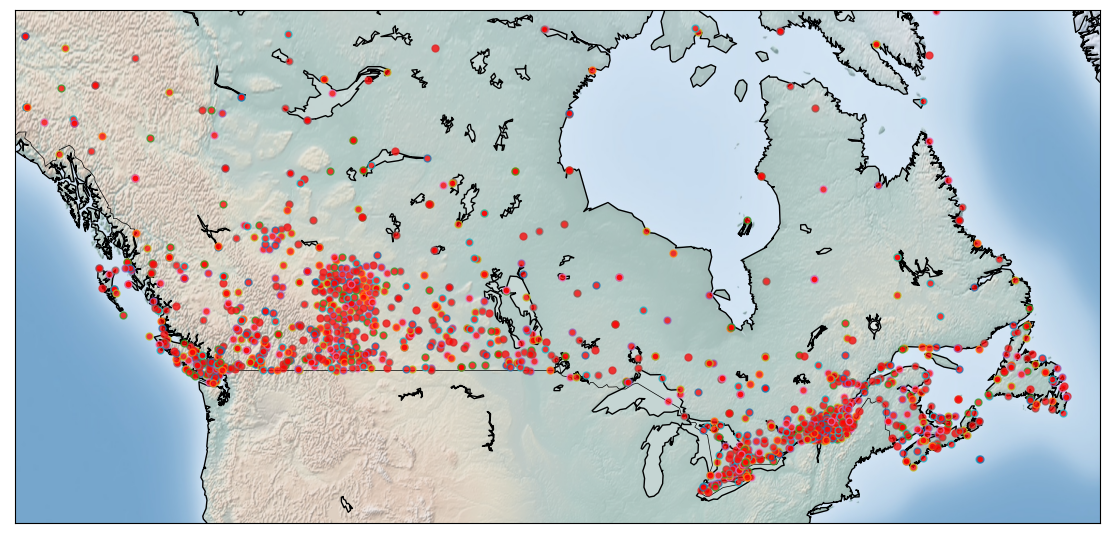

In [13]:
rcParams['figure.figsize'] = (14,10)

# latitude and longitud of Canada
llon=-140
ulon=-50
llat=40
ulat=65


df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) &(df['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        
xs,ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
df['xm']= xs.tolist()
df['ym'] =ys.tolist()

# Visualization
for index,row in df.iterrows():
    my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)

plt.show()

<a name="4"></a>
## <b> <font color='green'> 4. Station clustering based on their location ( Latitude & Longitude) </b> </font>

DBSCAN from sklearn can perform DBSCAN from a vector array or a distance matrix.

In our case, we will pass the NumPy array clus_dataset to find high-density core samples and expand the clusters from them.

In [19]:
sklearn.utils.check_random_state(1000)

clus_dataset = df[['xm','ym']]
clus_dataset = np.nan_to_num(clus_dataset)


clus_dataset = StandardScaler().fit_transform(clus_dataset)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(clus_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["clus_db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# a sample of clusters
df[["Stn_Name","Tx","Tm","clus_db"]].head(5)

,Stn_Name,Tx,Tm,clus_db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


In [20]:
set(labels) #outliers will be labeled with -1

{-1, 0, 1, 2, 3, 4}

Cluster 0, Avg Temp: -5.538747553816046
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


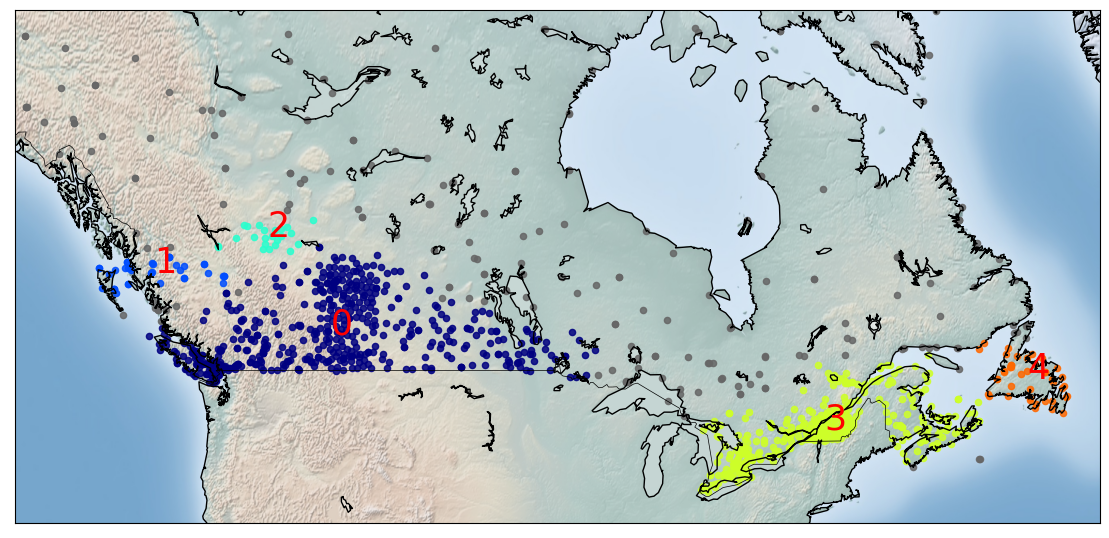

In [24]:
# visualizing

rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))


# visualization
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.clus_db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

<a name="5"></a>
## <b> <font color='green'> 5. Station clustering based on their location and temperature </b> </font>

In [26]:
sklearn.utils.check_random_state(1000)

clus_dataset = df[['xm','ym','Tx','Tm','Tn']]
clus_dataset = np.nan_to_num(clus_dataset)
clus_dataset = StandardScaler().fit_transform(clus_dataset)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(clus_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["clus_db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# a sample of clusters
df[["Stn_Name","Tx","Tm","clus_db"]].head(5)

,Stn_Name,Tx,Tm,clus_db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


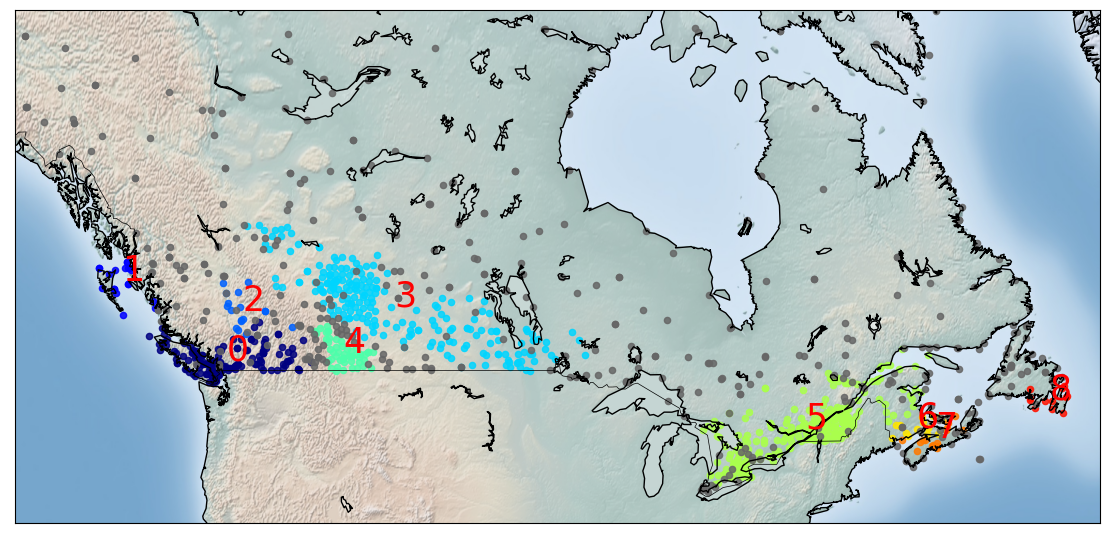

In [27]:
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

# Visualization
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.clus_db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

<a name="annex"></a>
## <b> <font color='green'> ANNEX </b> </font>

### About the dataset

<h4 align = "center">
Environment Canada    
Monthly Values for July - 2015	
</h4>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
border: 1px solid #dddddd;
text-align: left;
padding: 8px;
}

tr:nth-child(even) {
background-color: #dddddd;
} </style>

</head>
<body>

<table>
  <tr>
    <th>Name in the table</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td><font color = "green"><strong>Stn_Name</font></td>
    <td><font color = "green"><strong>Station Name</font</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Lat</font></td>
    <td><font color = "green"><strong>Latitude (North+, degrees)</font></td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Long</font></td>
    <td><font color = "green"><strong>Longitude (West - , degrees)</font></td>
  </tr>
  <tr>
    <td>Prov</td>
    <td>Province</td>
  </tr>
  <tr>
      <td> <font color = "green"><strong>Tm</strong></font></td>
      <td> <font color = "green"><strong>Mean Temperature (°C)</strong></td>
  </tr>
  <tr>
    <td>DwTm</td>
    <td>Days without Valid Mean Temperature</td>
  </tr>
  <tr>
    <td>D</td>
    <td>Mean Temperature difference from Normal (1981-2010) (°C)</td>
  </tr>
  <tr>
      <td><font color = "green"><strong>Tx</strong></font></td>
      <td><font color = "green"><strong>Highest Monthly Maximum Temperature (°C)</strong></font></td>
  </tr>
  <tr>
    <td>DwTx</td>
    <td>Days without Valid Maximum Temperature</td>
  </tr>
  <tr>
      <td><font color = "green"><strong>Tn</strong></font></td>
      <td><font color = "green"><strong>Lowest Monthly Minimum Temperature (°C)</strong></font></td>
  </tr>
  <tr>
    <td>DwTn</td>
    <td>Days without Valid Minimum Temperature</td>
  </tr>
  <tr>
    <td>S</td>
    <td>Snowfall (cm)</td>
  </tr>
  <tr>
    <td>DwS</td>
    <td>Days without Valid Snowfall</td>
  </tr>
  <tr>
    <td>S%N</td>
    <td>Percent of Normal (1981-2010) Snowfall</td>
  </tr>
  <tr>
    <td>P</td>
    <td>Total Precipitation (mm)</td>
  </tr>
  <tr>
    <td>DwP</td>
    <td>Days without Valid Precipitation</td>
  </tr>
  <tr>
    <td>P%N</td>
    <td>Percent of Normal (1981-2010) Precipitation</td>
  </tr>
  <tr>
    <td>S_G</td>
    <td>Snow on the ground at the end of the month (cm)</td>
  </tr>
  <tr>
    <td>Pd</td>
    <td>Number of days with Precipitation 1.0 mm or more</td>
  </tr>
  <tr>
    <td>BS</td>
    <td>Bright Sunshine (hours)</td>
  </tr>
  <tr>
    <td>DwBS</td>
    <td>Days without Valid Bright Sunshine</td>
  </tr>
  <tr>
    <td>BS%</td>
    <td>Percent of Normal (1981-2010) Bright Sunshine</td>
  </tr>
  <tr>
    <td>HDD</td>
    <td>Degree Days below 18 °C</td>
  </tr>
  <tr>
    <td>CDD</td>
    <td>Degree Days above 18 °C</td>
  </tr>
  <tr>
    <td>Stn_No</td>
    <td>Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).</td>
  </tr>
  <tr>
    <td>NA</td>
    <td>Not Available</td>
  </tr>

</table>

</body>
</html>


<a name="references"></a>
## <b> <font color='green'> References </b> </font>

<a href="https://www.coursera.org/professional-certificates/ibm-data-science" target='blanck'>IBM Data Science Course<a/>